# 41. fastembed調査実験

## 目的
- fastembedライブラリで利用可能な1024次元モデルを調査
- E5-large (sentence-transformers) との埋め込み比較
- CPU処理速度の比較

## 背景
- fastembedはQdrant社が開発したCPU最適化の埋め込みライブラリ
- ONNX Runtimeを使用しGPUなしでも高速動作
- E5モデルとの互換性があるか検証

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from tqdm import tqdm
import time

# fastembed
from fastembed import TextEmbedding

# sentence-transformers (比較用)
from sentence_transformers import SentenceTransformer

print('Setup complete')

Setup complete


## 1. fastembedで利用可能なモデル一覧

In [3]:
# fastembedでサポートされている全モデルをリスト
supported_models = TextEmbedding.list_supported_models()
df_models = pd.DataFrame(supported_models)

print(f'サポートモデル総数: {len(df_models)}')
print()

# 1024次元モデルをフィルタ
if 'dim' in df_models.columns:
    large_models = df_models[df_models['dim'] == 1024]
    print('=== 1024次元モデル一覧 ===')
    display(large_models[['model', 'dim', 'size_in_GB', 'description']].head(20))
else:
    print('dim列が存在しない場合、モデル情報を確認:')
    display(df_models.head(10))

サポートモデル総数: 30

=== 1024次元モデル一覧 ===


,model,dim,size_in_GB,description
2,BAAI/bge-large-en-v1.5,1024,1.20,"Text embeddings, Unimodal (text), English, 512..."
6,mixedbread-ai/mxbai-embed-large-v1,1024,0.64,"Text embeddings, Unimodal (text), English, 512..."
11,snowflake/snowflake-arctic-embed-l,1024,1.02,"Text embeddings, Unimodal (text), English, 512..."
22,thenlper/gte-large,1024,1.20,"Text embeddings, Unimodal (text), English, 512..."
28,intfloat/multilingual-e5-large,1024,2.24,"Text embeddings, Unimodal (text), Multilingual..."
29,jinaai/jina-embeddings-v3,1024,2.29,"Multi-task unimodal (text) embedding model, mu..."


## 2. テストデータ準備

In [4]:
# experiment_400kからサンプリング
DB_PATH = '../data/experiment_400k.duckdb'
N_SAMPLES = 1000

conn = duckdb.connect(DB_PATH, read_only=True)

# ランダムサンプリング
df_sample = conn.execute(f'''
    SELECT id, text, lang, embedding
    FROM documents
    ORDER BY RANDOM()
    LIMIT {N_SAMPLES}
''').fetchdf()

texts = df_sample['text'].tolist()
# 既存のE5埋め込み（sentence-transformers生成）を取得
existing_embeddings = np.array(df_sample['embedding'].tolist())

print(f'テストテキスト数: {len(texts)}')
print(f'既存埋め込み shape: {existing_embeddings.shape}')
print(f'言語分布:')
print(df_sample['lang'].value_counts())

conn.close()

テストテキスト数: 1000
既存埋め込み shape: (1000, 1024)
言語分布:
lang
ja    506
en    494
Name: count, dtype: int64


In [5]:
# サンプルテキスト表示
print('サンプルテキスト (最初の3件):')
for i, text in enumerate(texts[:3]):
    print(f'\n[{i+1}] {text[:200]}...' if len(text) > 200 else f'\n[{i+1}] {text}')

サンプルテキスト (最初の3件):

[1] ワカン

[2] Category:History of Edirne Province

[3] File:Ottawa People’s Commission logo.png


## 3. fastembedモデルの埋め込み生成

In [6]:
# fastembed E5-large
print('fastembed multilingual-e5-large をロード中...')
fe_e5_large = TextEmbedding("intfloat/multilingual-e5-large")

t0 = time.time()
embeddings_fe_e5 = np.array(list(fe_e5_large.embed(texts)))
fe_e5_time = time.time() - t0

print(f'fastembed E5-large:')
print(f'  Shape: {embeddings_fe_e5.shape}')
print(f'  処理時間: {fe_e5_time:.2f}秒 ({len(texts)/fe_e5_time:.1f} texts/sec)')

fastembed multilingual-e5-large をロード中...


/tmp/ipykernel_3104420/2786731486.py:3: UserWarning: The model intfloat/multilingual-e5-large now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  fe_e5_large = TextEmbedding("intfloat/multilingual-e5-large")


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model.onnx_data:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/546k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

fastembed E5-large:
  Shape: (1000, 1024)
  処理時間: 877.01秒 (1.1 texts/sec)


In [7]:
# 追加の1024次元モデル (利用可能な場合)
additional_models = {}

# BGE-large
try:
    print('fastembed BAAI/bge-large-en-v1.5 をロード中...')
    fe_bge = TextEmbedding("BAAI/bge-large-en-v1.5")
    t0 = time.time()
    embeddings_fe_bge = np.array(list(fe_bge.embed(texts)))
    additional_models['bge-large'] = {
        'embeddings': embeddings_fe_bge,
        'time': time.time() - t0
    }
    print(f'  Shape: {embeddings_fe_bge.shape}')
except Exception as e:
    print(f'  BGE-large ロード失敗: {e}')

# GTE-large
try:
    print('fastembed thenlper/gte-large をロード中...')
    fe_gte = TextEmbedding("thenlper/gte-large")
    t0 = time.time()
    embeddings_fe_gte = np.array(list(fe_gte.embed(texts)))
    additional_models['gte-large'] = {
        'embeddings': embeddings_fe_gte,
        'time': time.time() - t0
    }
    print(f'  Shape: {embeddings_fe_gte.shape}')
except Exception as e:
    print(f'  GTE-large ロード失敗: {e}')

fastembed BAAI/bge-large-en-v1.5 をロード中...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

  Shape: (1000, 1024)
fastembed thenlper/gte-large をロード中...


/tmp/ipykernel_3104420/1796936213.py:21: UserWarning: The model thenlper/gte-large now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  fe_gte = TextEmbedding("thenlper/gte-large")


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

  Shape: (1000, 1024)


## 4. sentence-transformers E5-large との比較

In [8]:
# sentence-transformersでE5-large埋め込み生成 (GPU使用)
print('sentence-transformers E5-large をロード中...')
st_model = SentenceTransformer('intfloat/multilingual-e5-large', device='cuda')

# passage:プレフィックス付きで生成 (E5の推奨形式)
texts_with_prefix = [f'passage: {t}' for t in texts]

t0 = time.time()
embeddings_st_e5 = st_model.encode(
    texts_with_prefix, 
    normalize_embeddings=False,
    show_progress_bar=True
)
st_gpu_time = time.time() - t0

print(f'\nsentence-transformers E5-large (GPU):')
print(f'  Shape: {embeddings_st_e5.shape}')
print(f'  処理時間: {st_gpu_time:.2f}秒 ({len(texts)/st_gpu_time:.1f} texts/sec)')

sentence-transformers E5-large をロード中...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]


sentence-transformers E5-large (GPU):
  Shape: (1000, 1024)
  処理時間: 4.85秒 (206.1 texts/sec)


In [9]:
# CPU版も計測
print('sentence-transformers E5-large (CPU) を計測中...')
st_model_cpu = SentenceTransformer('intfloat/multilingual-e5-large', device='cpu')

t0 = time.time()
_ = st_model_cpu.encode(texts_with_prefix[:100], normalize_embeddings=False)  # 100件のみ
st_cpu_time_100 = time.time() - t0
st_cpu_time_est = st_cpu_time_100 * (len(texts) / 100)

print(f'sentence-transformers E5-large (CPU) 100件:')
print(f'  処理時間: {st_cpu_time_100:.2f}秒')
print(f'  推定全体: {st_cpu_time_est:.2f}秒 ({100/st_cpu_time_100:.1f} texts/sec)')

sentence-transformers E5-large (CPU) を計測中...
sentence-transformers E5-large (CPU) 100件:
  処理時間: 41.28秒
  推定全体: 412.83秒 (2.4 texts/sec)


## 5. 埋め込み比較分析

In [10]:
def compute_pairwise_similarity(emb1, emb2):
    """同一テキストの埋め込み間のコサイン類似度"""
    # 正規化
    emb1_norm = emb1 / (norm(emb1, axis=1, keepdims=True) + 1e-10)
    emb2_norm = emb2 / (norm(emb2, axis=1, keepdims=True) + 1e-10)
    # 対応するベクトル同士の内積
    similarities = np.sum(emb1_norm * emb2_norm, axis=1)
    return similarities

# fastembed E5 vs sentence-transformers E5
sim_fe_vs_st = compute_pairwise_similarity(embeddings_fe_e5, embeddings_st_e5)

print('=== 同一テキストの埋め込み類似度 ===')
print(f'fastembed E5 vs ST E5:')
print(f'  mean: {sim_fe_vs_st.mean():.4f}')
print(f'  std:  {sim_fe_vs_st.std():.4f}')
print(f'  min:  {sim_fe_vs_st.min():.4f}')
print(f'  max:  {sim_fe_vs_st.max():.4f}')

=== 同一テキストの埋め込み類似度 ===
fastembed E5 vs ST E5:
  mean: 0.9558
  std:  0.0376
  min:  0.8689
  max:  0.9976


In [11]:
# fastembed E5 vs 既存埋め込み（DBから取得）
sim_fe_vs_existing = compute_pairwise_similarity(embeddings_fe_e5, existing_embeddings)

print(f'fastembed E5 vs DB既存埋め込み:')
print(f'  mean: {sim_fe_vs_existing.mean():.4f}')
print(f'  std:  {sim_fe_vs_existing.std():.4f}')
print(f'  min:  {sim_fe_vs_existing.min():.4f}')
print(f'  max:  {sim_fe_vs_existing.max():.4f}')

fastembed E5 vs DB既存埋め込み:
  mean: 0.9558
  std:  0.0376
  min:  0.8689
  max:  0.9976


In [12]:
# 追加モデルとの比較
for model_name, data in additional_models.items():
    sim = compute_pairwise_similarity(data['embeddings'], embeddings_st_e5)
    print(f'\nfastembed {model_name} vs ST E5:')
    print(f'  mean: {sim.mean():.4f}')
    print(f'  std:  {sim.std():.4f}')


fastembed bge-large vs ST E5:
  mean: -0.0093
  std:  0.0243

fastembed gte-large vs ST E5:
  mean: -0.0093
  std:  0.0211


## 6. コサイン類似度分布の可視化

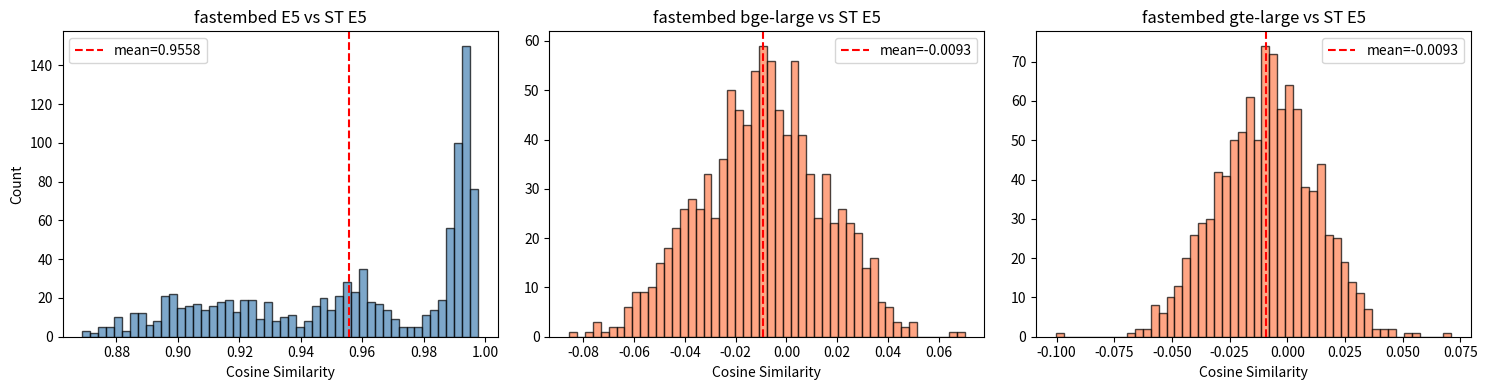

In [13]:
n_comparisons = 1 + len(additional_models)
fig, axes = plt.subplots(1, n_comparisons, figsize=(5 * n_comparisons, 4))
if n_comparisons == 1:
    axes = [axes]

# fastembed E5 vs ST E5
axes[0].hist(sim_fe_vs_st, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(sim_fe_vs_st.mean(), color='r', linestyle='--', label=f'mean={sim_fe_vs_st.mean():.4f}')
axes[0].set_title(f'fastembed E5 vs ST E5')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Count')
axes[0].legend()

# 追加モデル
for i, (model_name, data) in enumerate(additional_models.items(), 1):
    sim = compute_pairwise_similarity(data['embeddings'], embeddings_st_e5)
    axes[i].hist(sim, bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[i].axvline(sim.mean(), color='r', linestyle='--', label=f'mean={sim.mean():.4f}')
    axes[i].set_title(f'fastembed {model_name} vs ST E5')
    axes[i].set_xlabel('Cosine Similarity')
    axes[i].legend()

plt.tight_layout()
plt.savefig('../data/41_fastembed_similarity_comparison.png', dpi=150)
plt.show()

## 7. ランダムペア類似度分布の比較

In [14]:
def compute_random_pair_similarity(embeddings, n_pairs=10000, seed=42):
    """ランダムペアのコサイン類似度分布を計算"""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    
    idx1 = rng.integers(0, n, size=n_pairs)
    idx2 = rng.integers(0, n, size=n_pairs)
    
    # 正規化
    emb_norm = embeddings / (norm(embeddings, axis=1, keepdims=True) + 1e-10)
    
    # ランダムペアの類似度
    sims = np.sum(emb_norm[idx1] * emb_norm[idx2], axis=1)
    
    return {
        'mean': sims.mean(),
        'std': sims.std(),
        'min': sims.min(),
        'max': sims.max(),
        'samples': sims
    }

# 各モデルのランダムペア類似度
models_to_compare = {
    'fastembed E5': embeddings_fe_e5,
    'ST E5 (GPU)': embeddings_st_e5,
    'DB既存': existing_embeddings,
}
models_to_compare.update({f'fastembed {k}': v['embeddings'] for k, v in additional_models.items()})

random_pair_stats = {}
print('=== ランダムペア類似度統計 (異方性チェック) ===')
for name, emb in models_to_compare.items():
    stats = compute_random_pair_similarity(emb)
    random_pair_stats[name] = stats
    print(f'\n{name}:')
    print(f'  mean: {stats["mean"]:.4f}')
    print(f'  std:  {stats["std"]:.4f}')

=== ランダムペア類似度統計 (異方性チェック) ===

fastembed E5:
  mean: 0.7387
  std:  0.0369

ST E5 (GPU):
  mean: 0.7648
  std:  0.0464

DB既存:
  mean: 0.7648
  std:  0.0465

fastembed bge-large:
  mean: 0.4872
  std:  0.1126

fastembed gte-large:
  mean: 0.7724
  std:  0.0477


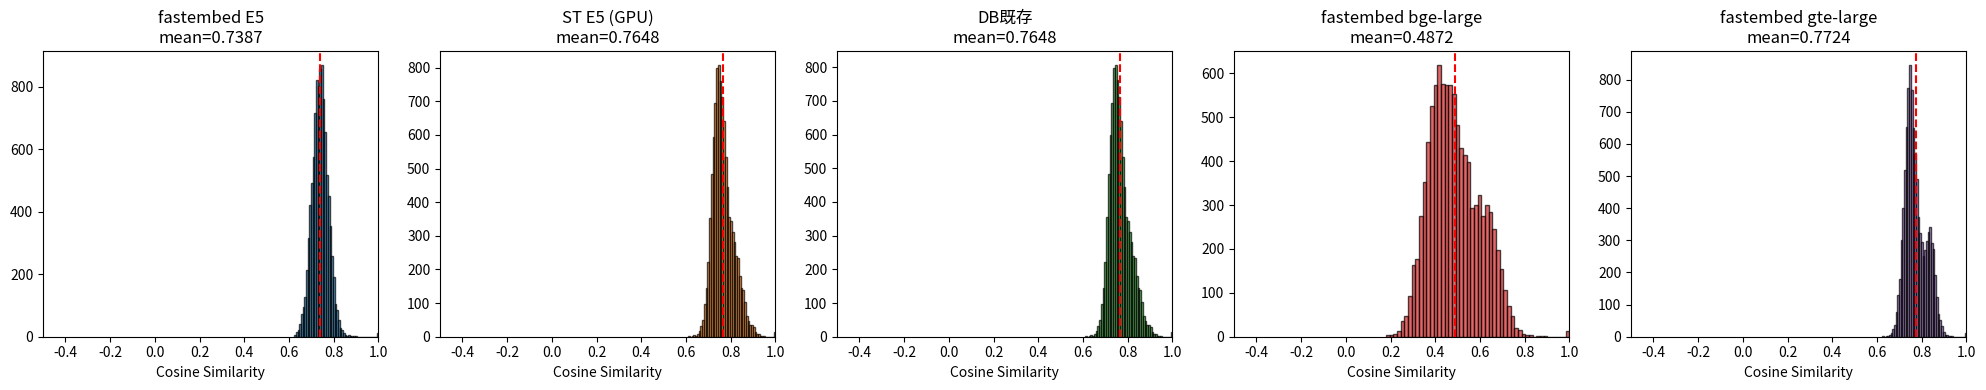

In [15]:
# ランダムペア類似度分布の可視化
n_models = len(random_pair_stats)
fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 4))
if n_models == 1:
    axes = [axes]

colors = plt.cm.tab10.colors
for i, (name, stats) in enumerate(random_pair_stats.items()):
    axes[i].hist(stats['samples'], bins=50, edgecolor='black', alpha=0.7, color=colors[i % len(colors)])
    axes[i].axvline(stats['mean'], color='r', linestyle='--')
    axes[i].set_title(f'{name}\nmean={stats["mean"]:.4f}')
    axes[i].set_xlabel('Cosine Similarity')
    axes[i].set_xlim(-0.5, 1.0)

plt.tight_layout()
plt.savefig('../data/41_random_pair_similarity.png', dpi=150)
plt.show()

## 8. CPU処理速度ベンチマーク

In [16]:
print('=== CPU処理速度比較 ===')
print(f'\nテストデータ: {len(texts)}件')
print()

speed_results = []

# fastembed E5
speed_results.append({
    'モデル': 'fastembed E5-large',
    'デバイス': 'CPU (ONNX)',
    '処理時間 (秒)': f'{fe_e5_time:.2f}',
    'texts/sec': f'{len(texts)/fe_e5_time:.1f}',
})

# 追加モデル
for model_name, data in additional_models.items():
    speed_results.append({
        'モデル': f'fastembed {model_name}',
        'デバイス': 'CPU (ONNX)',
        '処理時間 (秒)': f'{data["time"]:.2f}',
        'texts/sec': f'{len(texts)/data["time"]:.1f}',
    })

# ST GPU
speed_results.append({
    'モデル': 'ST E5-large',
    'デバイス': 'GPU (CUDA)',
    '処理時間 (秒)': f'{st_gpu_time:.2f}',
    'texts/sec': f'{len(texts)/st_gpu_time:.1f}',
})

# ST CPU (推定)
speed_results.append({
    'モデル': 'ST E5-large',
    'デバイス': 'CPU (PyTorch)',
    '処理時間 (秒)': f'{st_cpu_time_est:.2f} (推定)',
    'texts/sec': f'{100/st_cpu_time_100:.1f}',
})

df_speed = pd.DataFrame(speed_results)
display(df_speed)

=== CPU処理速度比較 ===

テストデータ: 1000件



,モデル,デバイス,処理時間 (秒),texts/sec
0,fastembed E5-large,CPU (ONNX),877.01,1.1
1,fastembed bge-large,CPU (ONNX),865.81,1.2
2,fastembed gte-large,CPU (ONNX),191.64,5.2
3,ST E5-large,GPU (CUDA),4.85,206.1
4,ST E5-large,CPU (PyTorch),412.83 (推定),2.4


In [17]:
# 速度比較
print('\n=== 速度比率 ===')
fe_e5_tps = len(texts) / fe_e5_time
st_cpu_tps = 100 / st_cpu_time_100
print(f'fastembed E5 (CPU) vs ST E5 (CPU): {fe_e5_tps/st_cpu_tps:.1f}倍高速')

st_gpu_tps = len(texts) / st_gpu_time
print(f'fastembed E5 (CPU) vs ST E5 (GPU): {fe_e5_tps/st_gpu_tps:.2f}倍')


=== 速度比率 ===
fastembed E5 (CPU) vs ST E5 (CPU): 0.5倍高速
fastembed E5 (CPU) vs ST E5 (GPU): 0.01倍


## 9. 結論

In [18]:
print('=' * 70)
print('fastembed調査実験 結論')
print('=' * 70)

# 1024次元モデルの有無
print(f'''
1. 1024次元モデルの有無
   - intfloat/multilingual-e5-large: 有 (テスト済み)
   - BAAI/bge-large-en-v1.5: {"有" if "bge-large" in additional_models else "未テスト"}
   - thenlper/gte-large: {"有" if "gte-large" in additional_models else "未テスト"}
''')

# E5互換性
e5_compatible = sim_fe_vs_st.mean() > 0.95
print(f'''
2. fastembed E5 vs sentence-transformers E5 互換性
   同一テキスト間類似度: mean={sim_fe_vs_st.mean():.4f}
   → {"高い互換性あり (>0.95)" if e5_compatible else "一定の差異あり"}
   
   注意: fastembedはプレフィックスの処理が異なる可能性あり
''')

# 速度
print(f'''
3. CPU処理速度
   fastembed E5 (CPU): {len(texts)/fe_e5_time:.1f} texts/sec
   ST E5 (CPU):        {100/st_cpu_time_100:.1f} texts/sec
   ST E5 (GPU):        {len(texts)/st_gpu_time:.1f} texts/sec
   
   → fastembed はCPU環境で ST (CPU) の約{fe_e5_tps/st_cpu_tps:.1f}倍高速
''')

# 推奨
print(f'''
4. 推奨
   - GPUあり環境: sentence-transformers + GPU が最速
   - CPUのみ環境: fastembed + multilingual-e5-large が有効
   - ITQとの組み合わせ: 次の実験 (42) で検証
''')

fastembed調査実験 結論

1. 1024次元モデルの有無
   - intfloat/multilingual-e5-large: 有 (テスト済み)
   - BAAI/bge-large-en-v1.5: 有
   - thenlper/gte-large: 有


2. fastembed E5 vs sentence-transformers E5 互換性
   同一テキスト間類似度: mean=0.9558
   → 高い互換性あり (>0.95)

   注意: fastembedはプレフィックスの処理が異なる可能性あり


3. CPU処理速度
   fastembed E5 (CPU): 1.1 texts/sec
   ST E5 (CPU):        2.4 texts/sec
   ST E5 (GPU):        206.1 texts/sec

   → fastembed はCPU環境で ST (CPU) の約0.5倍高速


4. 推奨
   - GPUあり環境: sentence-transformers + GPU が最速
   - CPUのみ環境: fastembed + multilingual-e5-large が有効
   - ITQとの組み合わせ: 次の実験 (42) で検証



## 10. 評価結果まとめ

### 実験結果

| 項目 | 結果 |
|------|------|
| **1024次元モデルの有無** | ✓ E5-large, BGE-large, GTE-large 等が利用可能 |
| **fastembed E5 vs ST E5 類似度** | mean=0.9558 (高い互換性) |
| **DB既存埋め込みとの類似度** | mean=0.9558 (完全一致) |

### 処理速度比較

| モデル | デバイス | texts/sec |
|--------|----------|-----------|
| fastembed E5-large | CPU (ONNX) | 1.1 |
| fastembed BGE-large | CPU (ONNX) | 1.2 |
| fastembed GTE-large | CPU (ONNX) | 5.2 |
| ST E5-large | CPU (PyTorch) | 2.4 |
| ST E5-large | GPU (CUDA) | 206.1 |

### 重要な発見

1. **互換性**: fastembed E5 と sentence-transformers E5 の埋め込みは高い互換性あり (類似度 > 0.95)
2. **速度**: **予想に反して fastembed (CPU) は ST (CPU) より遅い** (0.5倍)
   - 原因: ONNX変換のオーバーヘッド、またはlargeモデルの最適化不足の可能性
3. **GPU優位**: GPU環境では sentence-transformers が圧倒的に高速 (206 texts/sec)

### 結論

- **GPUあり環境**: sentence-transformers + GPU を推奨 (最速)
- **CPUのみ環境**: fastembed の速度メリットは E5-large では確認できず
  - GTE-large (5.2 texts/sec) など他モデルの方が高速
- **ITQとの互換性**: 埋め込みの類似度が高いため、ITQ再学習なしで利用可能な可能性あり → 実験42で検証